In [1]:
import pandas as pd
import spacy

In [3]:
df = pd.read_parquet("dataset_processed.parquet")

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [6]:
df.value_counts('label')

,count
label,
0,22554
1,22554


In [7]:
sampled_df = pd.concat([
    df[df['label'] == 0].sample(n=22554, random_state=42),
    df[df['label'] == 1].sample(n=22554, random_state=42)
])

In [8]:
sampled_df.reset_index(drop=True, inplace=True)

In [9]:
print(sampled_df.value_counts('label'))

label
0    22554
1    22554
Name: count, dtype: int64


In [10]:
df = sampled_df

In [11]:
df.head()

,articles,label
0,david martosko us political editor com washing...,0
1,indeed obamacare passed 2009 without single re...,0
2,former alaska governor sarah palin blasted hyp...,0
3,discover thomson david ingram 5 min read new y...,0
4,uc berkeley welcoming place conservative stude...,0


In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [20]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['articles'])

In [21]:
tokenizer.fit_on_texts(test_df['articles'])

In [22]:
X_train = tokenizer.texts_to_sequences(train_df['articles'])
X_train = pad_sequences(X_train, maxlen=100)

X_test = tokenizer.texts_to_sequences(test_df['articles'])
X_test = pad_sequences(X_test, maxlen=100)

In [23]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df['label'])
y_train = to_categorical(y_train)

y_test = label_encoder.transform(test_df['label'])
y_test = to_categorical(y_test)

In [26]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=200),
    LSTM(200, dropout=0.5, recurrent_dropout=0.5),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.5))
])

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # tô usando entropia cruzada como visto nas aulas, e adam pois ele é muito bom.

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia final do modelo: {accuracy}')

Epoch 1/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 226s 440ms/step - accuracy: 0.6906 - loss: 1.1998 - val_accuracy: 0.7531 - val_loss: 0.5215
Epoch 2/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 248s 414ms/step - accuracy: 0.7789 - loss: 0.5019 - val_accuracy: 0.7656 - val_loss: 0.4937
Epoch 3/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 213s 420ms/step - accuracy: 0.8143 - loss: 0.4516 - val_accuracy: 0.7670 - val_loss: 0.4959
Epoch 4/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 260s 417ms/step - accuracy: 0.8314 - loss: 0.4247 - val_accuracy: 0.7670 - val_loss: 0.4874
Epoch 5/5
508/508 ━━━━━━━━━━━━━━━━━━━━ 261s 415ms/step - accuracy: 0.8419 - loss: 0.4044 - val_accuracy: 0.7642 - val_loss: 0.4864
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.7730 - loss: 0.4865
Acurácia final do modelo: 0.770117461681366


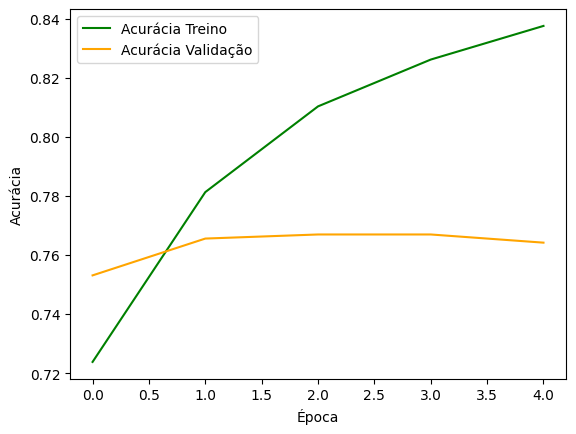

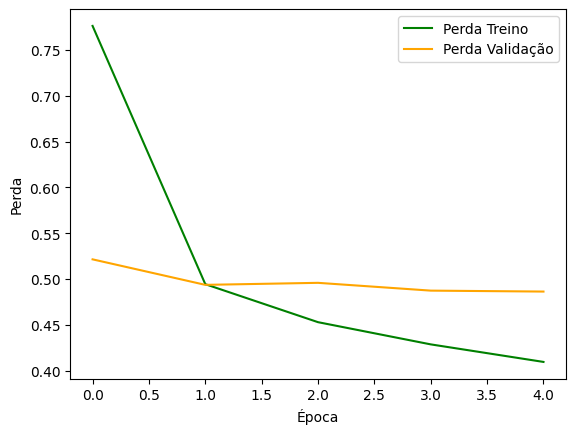

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(train_accuracy, label='Acurácia Treino', color="green")
plt.plot(val_accuracy, label='Acurácia Validação', color="orange")
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(train_loss, label='Perda Treino', color="green")
plt.plot(val_loss, label='Perda Validação', color="orange")
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()